## Preprocessing of the dataset into a standard and normalised format

### Import the dataset

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.patches as mpatches
import numpy as np
import calendar
import datetime
import pytz
import scipy.stats
import dateutil.parser
import time
#import requests

from matplotlib import pyplot as plt
from scipy.stats import zscore
from math import sqrt
from alive_progress import alive_bar
#from json.decoder import JSONDecodeError

# Load the dataset
df = pd.read_csv('Dataset/1900_2021_DISASTERS.csv')

# View the dataset
df.head()

,Year,Seq,Glide,Disaster Group,Disaster Subgroup,Disaster Type,Disaster Subtype,Disaster Subsubtype,Event Name,Country,...,No Affected,No Homeless,Total Affected,Insured Damages ('000 US$),Total Damages ('000 US$),CPI,Adm Level,Admin1 Code,Admin2 Code,Geo Locations
0,1900,9002,NaN,Natural,Climatological,Drought,Drought,NaN,NaN,Cabo Verde,...,NaN,NaN,NaN,NaN,NaN,3.221647,NaN,NaN,NaN,NaN
1,1900,9001,NaN,Natural,Climatological,Drought,Drought,NaN,NaN,India,...,NaN,NaN,NaN,NaN,NaN,3.221647,NaN,NaN,NaN,NaN
2,1902,12,NaN,Natural,Geophysical,Earthquake,Ground movement,NaN,NaN,Guatemala,...,NaN,NaN,NaN,NaN,25000.0,3.350513,NaN,NaN,NaN,NaN
3,1902,3,NaN,Natural,Geophysical,Volcanic activity,Ash fall,NaN,Santa Maria,Guatemala,...,NaN,NaN,NaN,NaN,NaN,3.350513,NaN,NaN,NaN,NaN
4,1902,10,NaN,Natural,Geophysical,Volcanic activity,Ash fall,NaN,Santa Maria,Guatemala,...,NaN,NaN,NaN,NaN,NaN,3.350513,NaN,NaN,NaN,NaN


### Calculate the percentage of missing values in each column

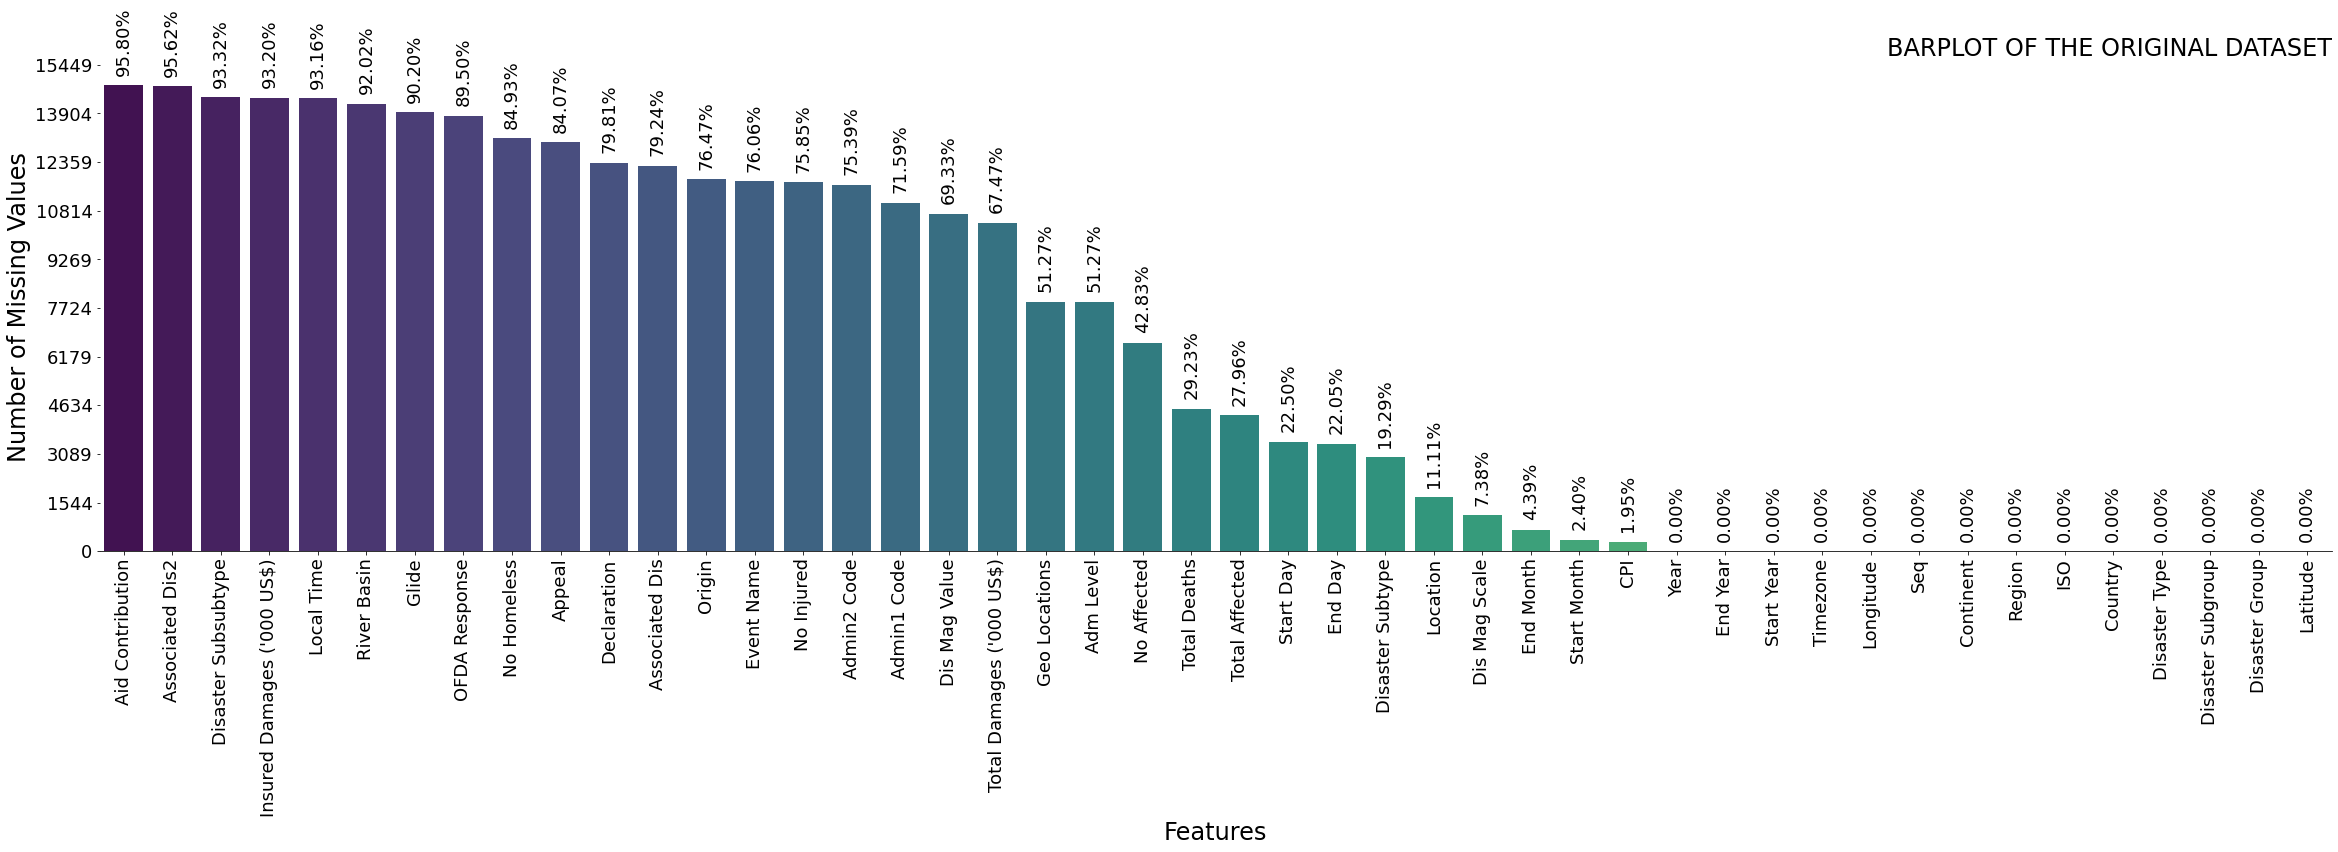

In [2]:
# Calculate the number of missing values in each column
missing = df.isna().sum()

# Sort the missing values in descending order
missing = missing.sort_values(ascending=False)

# Set the figure size to 36 inches wide and 28 inches tall
plt.figure(figsize=(40, 9))

# Plot the missing values in a bar plot and store the AxesSubplot object in a variable
ax = sns.barplot(x=missing.index, y=missing.values/len(df)*100, palette='viridis')

plt.title("BARPLOT OF THE ORIGINAL DATASET", loc="right", fontsize=24)

# Set the x-axis labels to be rotated 90 degrees
plt.xticks(rotation=90, fontsize=18)

plt.yticks(fontsize=18)

# Set the x-axis label
plt.xlabel("Features", fontsize=24)

# Set the y-axis label
plt.ylabel("Number of Missing Values", fontsize=24)

yticks = np.abs(np.linspace(0, 100, 11))
ytick_labels = yticks / 100 * max(missing)

ax.set_yticks(yticks)

ytick_labels = ytick_labels.astype(int)
ax.set_yticklabels(ytick_labels)

# Loop through the bars and add the values on top of the bars
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2, p.get_height() + 2, '{:.2f}%'.format(p.get_height()), 
            ha="center", va="bottom", rotation=90, fontsize=18)
    
# Set the bottom and left spine to be visible
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(False)

# Set all other spines to be invisible
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Show the plot
#plt.show()

# Save the figure
plt.savefig('Analysis/Plots/dataset-missing-values-barplot-original.png', facecolor='white', bbox_inches='tight')

### Remove unnecessary columns from the dataset

In [3]:
# Drop useless columns
df = df.drop(['Adm Level', 'Admin1 Code', 'Admin2 Code', 'Geo Locations', 'Disaster Group', 'Year', 'Glide', 'Seq', 'Local Time'], axis=1)

### Plot the correlations between different columns in the dataset for each group based on the Disaster Magnitude Scale.

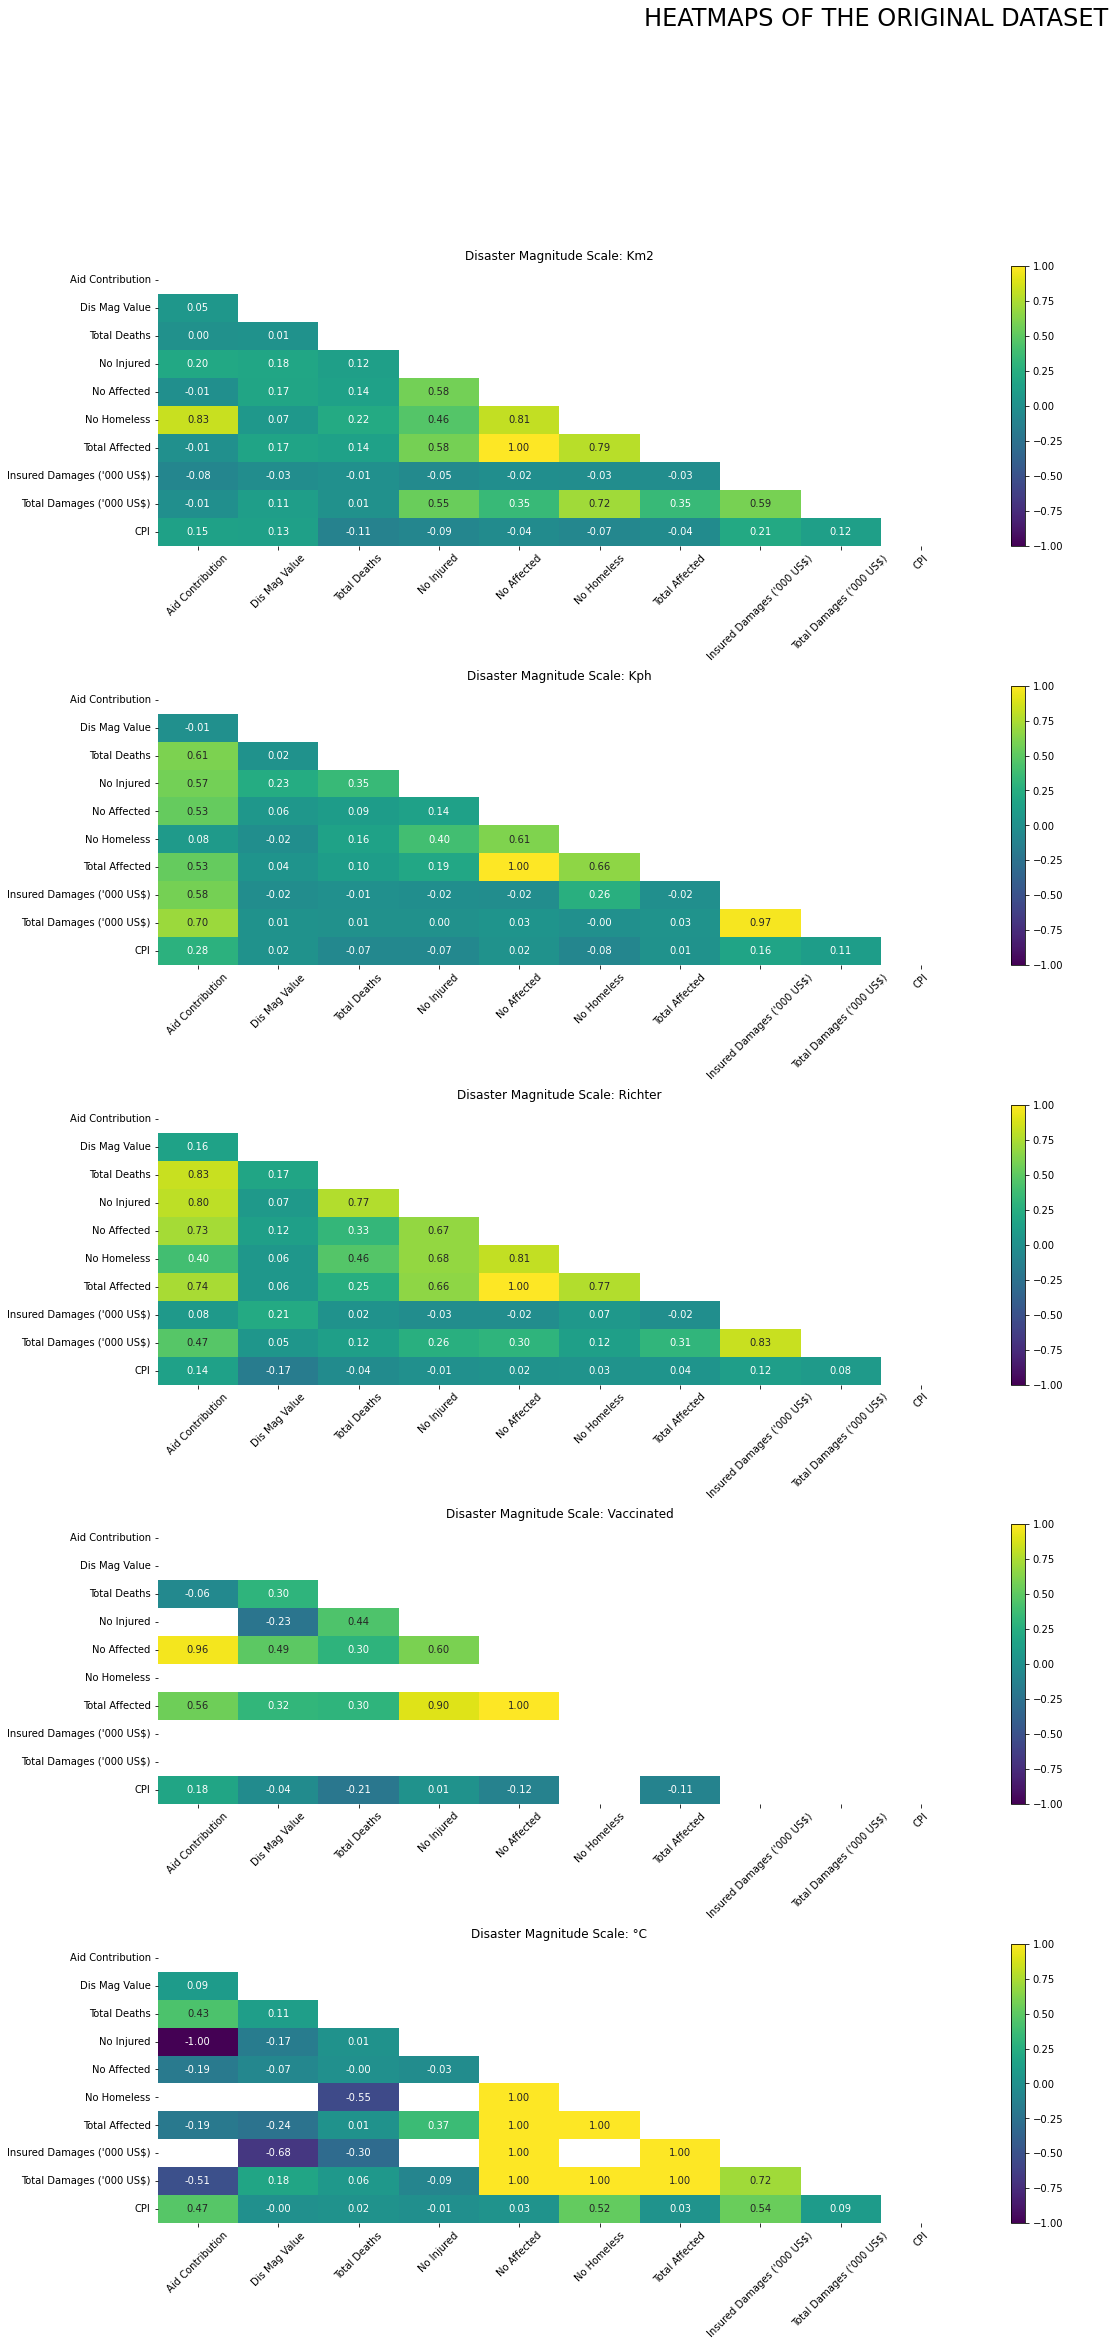

In [4]:
# Group the data by the Dis Mag Scale column
groups = df.groupby('Dis Mag Scale')

# Create a figure and an array of subplots
fig, axs = plt.subplots(nrows=len(groups), figsize=(18, 36))

# Select the columns to include in the heatmap
columns_to_include = ['Aid Contribution', 'Dis Mag Value', 'Total Deaths', 'No Injured', 'No Affected', 'No Homeless', 'Total Affected', "Insured Damages ('000 US$)", "Total Damages ('000 US$)", 'CPI']


# Iterate through the groups
for i, (name, group) in enumerate(groups):
    # Calculate the correlations for each group
    corr = group[columns_to_include].corr()

    # Create the mask for the lower triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Plot the heatmap for each group using heatmap
    sns.heatmap(corr, ax=axs[i], cmap="viridis", annot=True, fmt=".2f", vmin=-1, vmax=1, center=0, cbar=False, mask=mask)
    
    axs[i].set_title(f'Disaster Magnitude Scale: {name}')
    
    # Rotate the x tick labels by 45 degrees
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45)
    
    # Set the line width of the border
    for key, spine in axs[i].spines.items():
        spine.set_linewidth(3)
        
    # Add a color bar to each plot
    cbar = axs[i].figure.colorbar(axs[i].collections[0], ax=axs[i])
    
# Adjust the layout
plt.subplots_adjust(hspace=0.5)

# Add a title
plt.suptitle('HEATMAPS OF THE ORIGINAL DATASET', fontsize=24, ha="left")

# Save the figure
plt.savefig('Analysis/Plots/dataset-grouped-correlation-heathmap-original.png', facecolor='white', bbox_inches='tight')

#### The above heatmap suggests that disasters tend to have a greater impact on those who are already vulnerable, such as those who are injured or homeless.

### View the data types of the columns in the dataframe.

In [5]:
df.dtypes.sort_values(ascending=False)

Disaster Subgroup              object
Origin                         object
River Basin                    object
Timezone                       object
Disaster Type                  object
Declaration                    object
Appeal                         object
OFDA Response                  object
Associated Dis2                object
Associated Dis                 object
Dis Mag Scale                  object
Location                       object
Region                         object
ISO                            object
Country                        object
Event Name                     object
Disaster Subsubtype            object
Disaster Subtype               object
Continent                      object
End Day                       float64
Total Damages ('000 US$)      float64
Insured Damages ('000 US$)    float64
Total Affected                float64
No Homeless                   float64
No Affected                   float64
No Injured                    float64
Total Deaths

### Plot the values of categorical variables

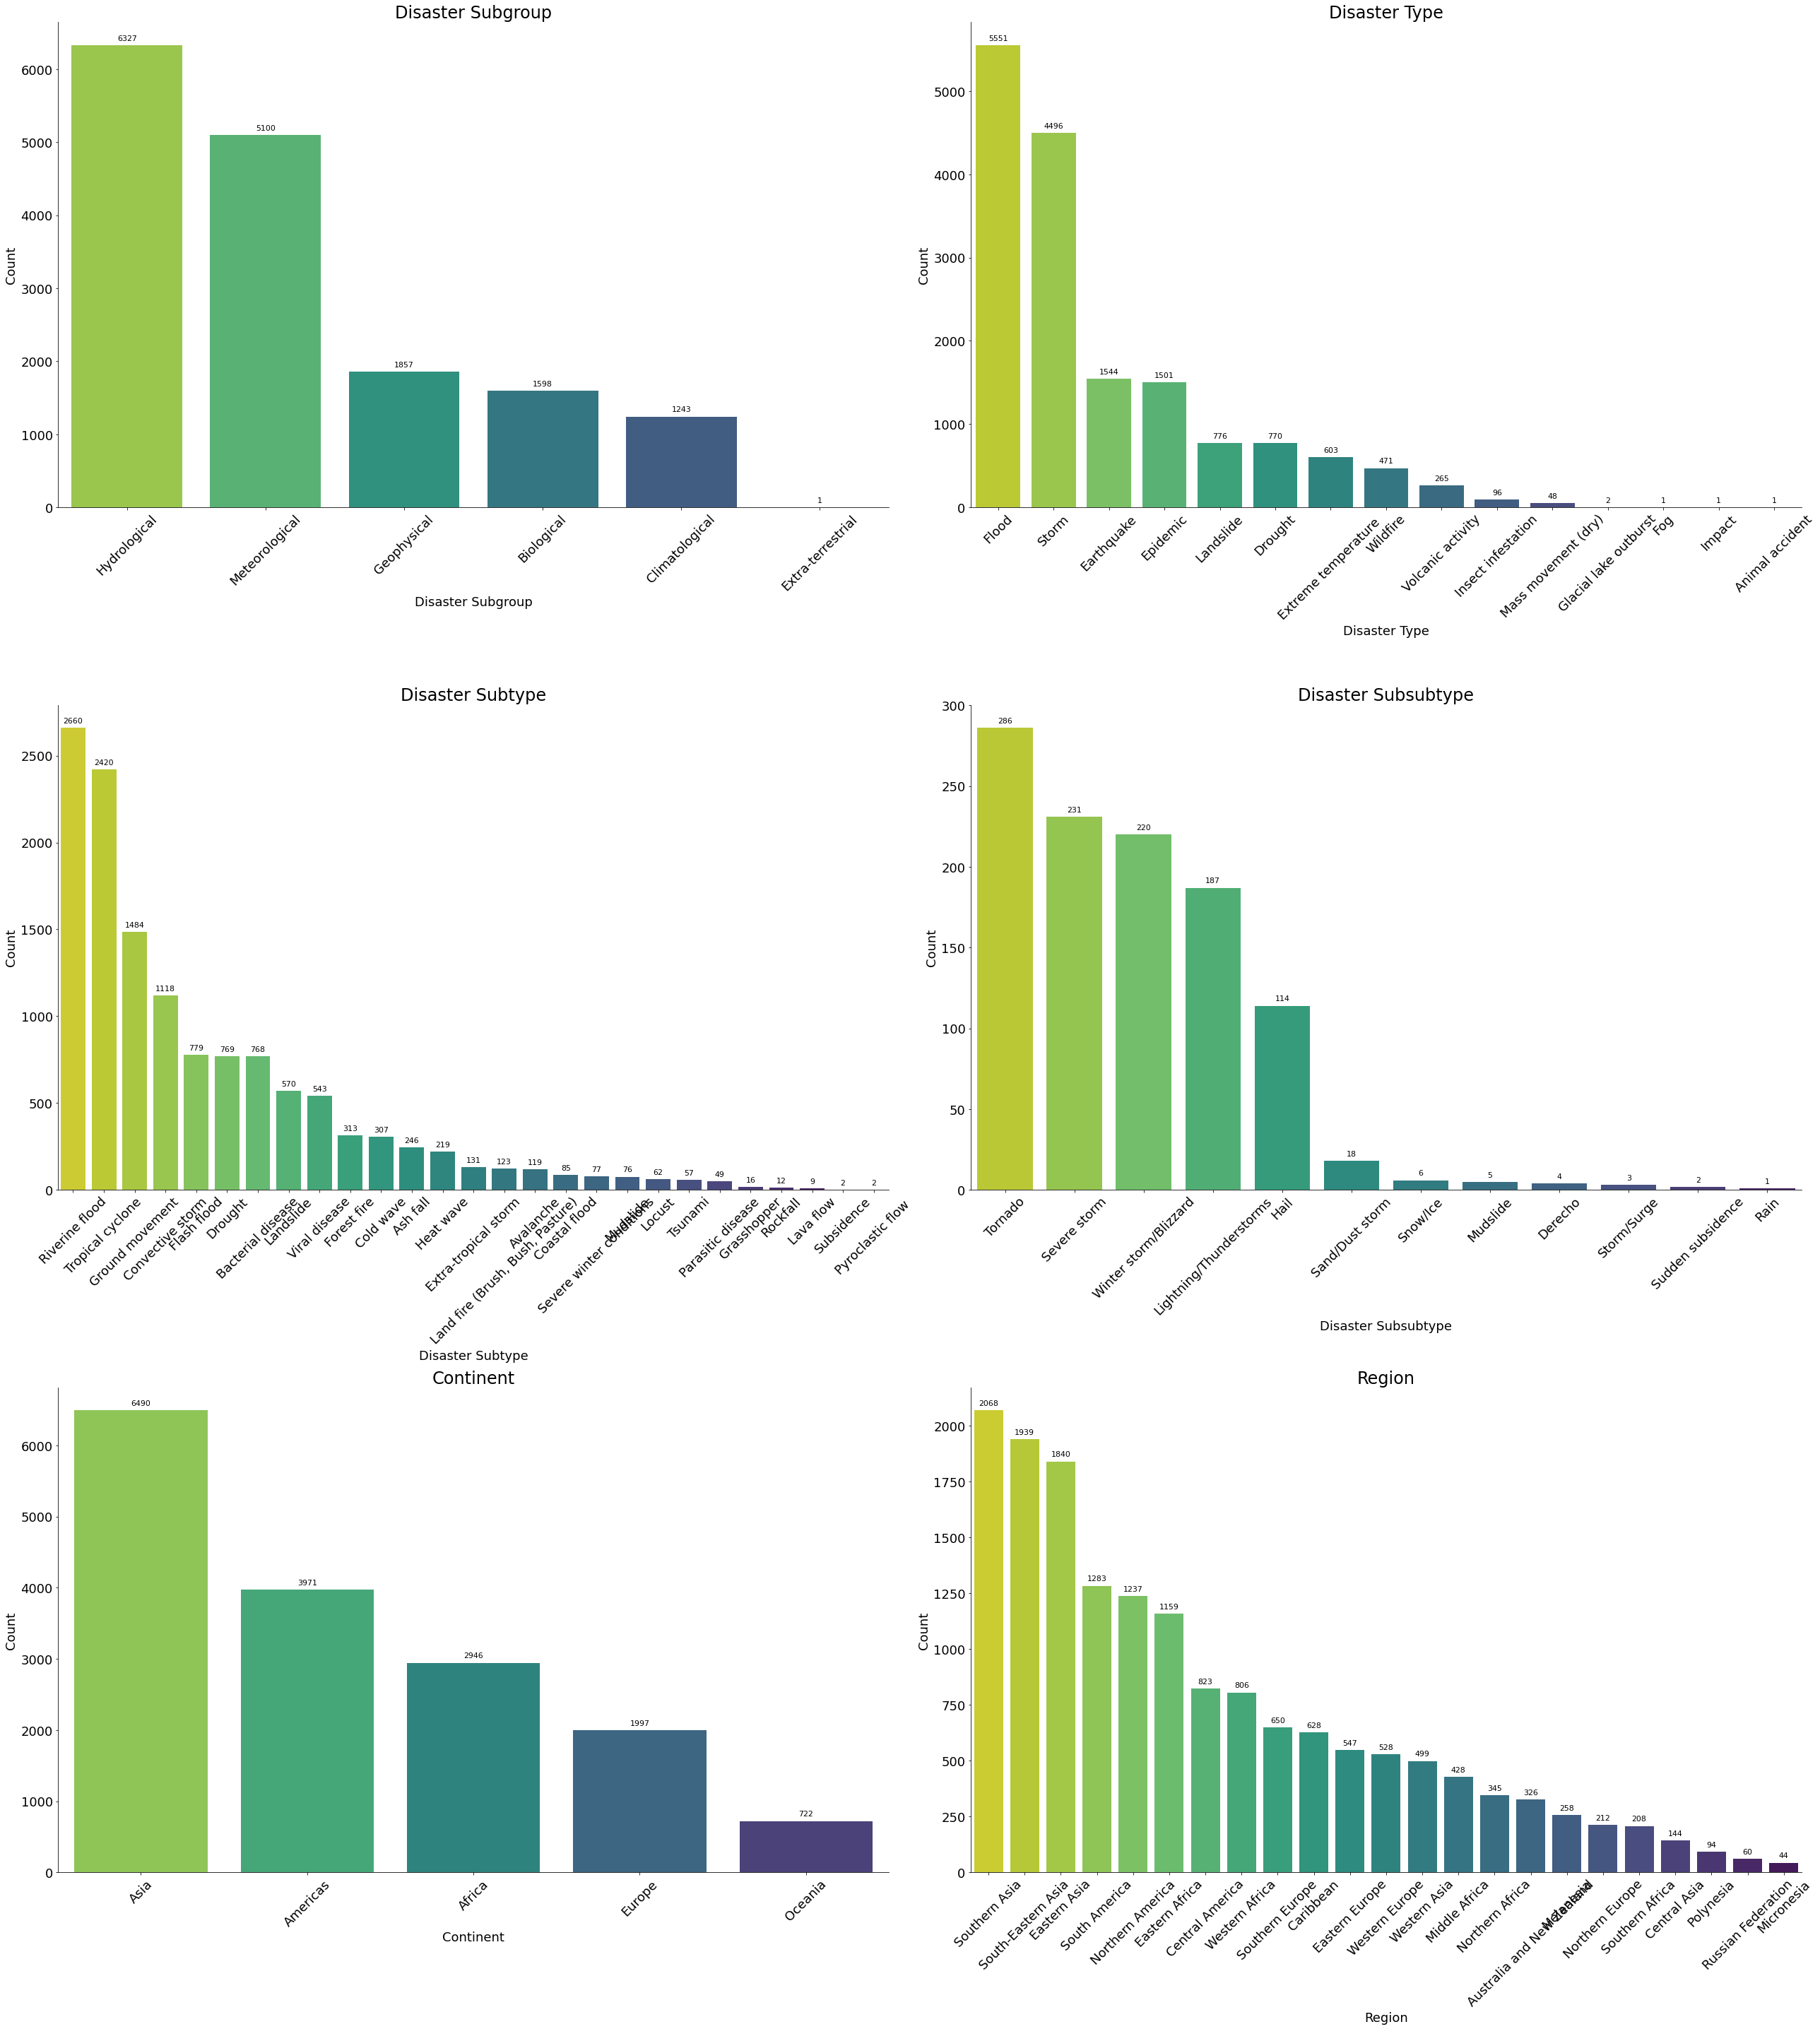

In [6]:
# Create figure
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(36, 40))

# Plot 1
plot1 = sns.barplot(
    x=df['Disaster Subgroup'].value_counts().index,
    y=df['Disaster Subgroup'].value_counts(),
    hue=df['Disaster Subgroup'].value_counts(),
    orient='v', dodge=False, ax=ax[0,0], palette='viridis')
ax[0,0].set_xlabel('Disaster Subgroup', fontsize=18)
ax[0,0].set_ylabel('Count', fontsize=18)
ax[0,0].set_title('Disaster Subgroup', fontsize=24)
ax[0, 0].tick_params(labelsize = 18)
ax[0,0].spines['bottom'].set_visible(True)
ax[0,0].spines['left'].set_visible(True)
ax[0,0].spines['top'].set_visible(False)
ax[0,0].spines['right'].set_visible(False)
for item in plot1.get_xticklabels():
    item.set_rotation(45)
ax[0,0].legend_.remove()
for p in ax[0,0].patches:
    ax[0,0].annotate("{:.0f}".format(p.get_height()),
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', fontsize=11, color='black', xytext=(0, 10),
                     textcoords='offset points')
    
# Plot 2
plot2 =sns.barplot(
    x=df['Disaster Type'].value_counts().index,
    y=df['Disaster Type'].value_counts(),
    hue=df['Disaster Type'].value_counts(),
    orient='v', dodge=False, ax=ax[0,1], palette='viridis')
ax[0,1].set_xlabel('Disaster Type', fontsize=18)
ax[0,1].set_ylabel('Count', fontsize=18)
ax[0,1].set_title('Disaster Type', fontsize=24)
ax[0, 1].tick_params(labelsize = 18)
ax[0,1].spines['bottom'].set_visible(True)
ax[0,1].spines['left'].set_visible(True)
ax[0,1].spines['top'].set_visible(False)
ax[0,1].spines['right'].set_visible(False)
for item in plot2.get_xticklabels():
    item.set_rotation(45)
ax[0,1].legend_.remove()
for p in ax[0,1].patches:
    ax[0,1].annotate("{:.0f}".format(p.get_height()),
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', fontsize=11, color='black', xytext=(0, 10),
                     textcoords='offset points')
    
# Plot 3
plot3 =sns.barplot(
    x=df['Disaster Subtype'].value_counts().index,
    y=df['Disaster Subtype'].value_counts(),
    hue=df['Disaster Subtype'].value_counts(),
    orient='v', dodge=False, ax=ax[1,0], palette='viridis')
ax[1,0].set_xlabel('Disaster Subtype', fontsize=18)
ax[1,0].set_ylabel('Count', fontsize=18)
ax[1,0].set_title('Disaster Subtype', fontsize=24)
ax[1, 0].tick_params(labelsize = 18)
ax[1,0].spines['bottom'].set_visible(True)
ax[1,0].spines['left'].set_visible(True)
ax[1,0].spines['top'].set_visible(False)
ax[1,0].spines['right'].set_visible(False)
for item in plot3.get_xticklabels():
    item.set_rotation(45)
ax[1,0].legend_.remove()
for p in ax[1,0].patches:
    ax[1,0].annotate("{:.0f}".format(p.get_height()),
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', fontsize=11, color='black', xytext=(0, 10),
                     textcoords='offset points')
    
# Plot 4
plot4 =sns.barplot(x=df['Disaster Subsubtype'].value_counts().index,
                   y=df['Disaster Subsubtype'].value_counts(),
                   hue=df['Disaster Subsubtype'].value_counts(),
                   orient='v', dodge=False, ax=ax[1,1], palette='viridis')
ax[1,1].set_xlabel('Disaster Subsubtype', fontsize=18)
ax[1,1].set_ylabel('Count', fontsize=18)
ax[1,1].set_title('Disaster Subsubtype', fontsize=24)
ax[1, 1].tick_params(labelsize = 18)
ax[1,1].spines['bottom'].set_visible(True)
ax[1,1].spines['left'].set_visible(True)
ax[1,1].spines['top'].set_visible(False)
ax[1,1].spines['right'].set_visible(False)
for item in plot4.get_xticklabels():
    item.set_rotation(45)
ax[1,1].legend_.remove()
for p in ax[1,1].patches:
    ax[1,1].annotate("{:.0f}".format(p.get_height()),
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', fontsize=11, color='black', xytext=(0, 10),
                     textcoords='offset points')
    
# Plot 5
plot5 =sns.barplot(x=df['Continent'].value_counts().index,
                   y=df['Continent'].value_counts(),
                   hue=df['Continent'].value_counts(),
                   orient='v', dodge=False, ax=ax[2,0],
                   palette='viridis')
ax[2,0].set_xlabel('Continent', fontsize=18)
ax[2,0].set_ylabel('Count', fontsize=18)
ax[2,0].set_title('Continent', fontsize=24)
ax[2, 0].tick_params(labelsize = 18)
ax[2,0].spines['bottom'].set_visible(True)
ax[2,0].spines['left'].set_visible(True)
ax[2,0].spines['top'].set_visible(False)
ax[2,0].spines['right'].set_visible(False)

for item in plot5.get_xticklabels():
    item.set_rotation(45)
ax[2,0].legend_.remove()
for p in ax[2,0].patches:
    ax[2,0].annotate("{:.0f}".format(p.get_height()),
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', fontsize=11, color='black', xytext=(0, 10),
                     textcoords='offset points')
    
# Plot 6
plot6 =sns.barplot(x=df['Region'].value_counts().index,
                   y=df['Region'].value_counts(),
                   hue=df['Region'].value_counts(),
                   orient='v',
                   dodge=False,
                   ax=ax[2,1],
                   palette='viridis')
ax[2,1].set_xlabel('Region', fontsize=18)
ax[2,1].set_ylabel('Count', fontsize=18)
ax[2,1].set_title('Region', fontsize=24)
ax[2, 1].tick_params(labelsize = 18)
ax[2,1].spines['bottom'].set_visible(True)
ax[2,1].spines['left'].set_visible(True)
ax[2,1].spines['top'].set_visible(False)
ax[2,1].spines['right'].set_visible(False)
for item in plot6.get_xticklabels():
    item.set_rotation(45)
ax[2,1].legend_.remove()
for p in ax[2,1].patches:
    ax[2,1].annotate("{:.0f}".format(p.get_height()),
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', fontsize=11, color='black', xytext=(0, 10),
                     textcoords='offset points')
    
# Set to tight layout
plt.tight_layout()
# Save figure
plt.savefig('Analysis/Plots/dataset-categorial-values-barplot-original.png', facecolor='white', bbox_inches='tight')

### Iterate through the columns in the dataframe, convert to lowercase and strip leading or trailing whitespace

In [7]:
# Make all cathegorical features homogenous, useful for sentimental analysis
cols = ['Disaster Subgroup', 'Disaster Type', 'Disaster Subtype', 'Disaster Subsubtype', 'Event Name', 'Country', 'ISO', 'Region', 'Continent', 'Location', 'Origin', 'Associated Dis', 'Associated Dis2', 'OFDA Response', 'Appeal', 'Declaration', 'Dis Mag Scale', 'River Basin']

for col in cols:
    df[col] = df[col].str.lower()
    df[col] = df[col].str.strip()

### Linearly interpolate missing values of dates

In [8]:
# Linearly interpolate numeric columns
numeric = df[['Start Day', 'Start Month', 'End Day', 'End Month']]
              #, 'CPI','Total Affected', 'No Homeless', 'No Affected', 'No Injured', 'Total Deaths']]
numeric_columns = numeric.columns

df[numeric_columns] = df[numeric_columns].interpolate(method='linear',limit_direction='forward')

# Calculate the median and interquartile range of the date columns
start_month_median = df['Start Month'].median()
start_month_iqr = df['Start Month'].quantile(0.75) - df['Start Month'].quantile(0.25)

start_day_median = df['Start Day'].median()
start_day_iqr = df['Start Day'].quantile(0.75) - df['Start Day'].quantile(0.25)

end_month_median = df['End Month'].median()
end_month_iqr = df['End Month'].quantile(0.75) - df['End Month'].quantile(0.25)

end_day_median = df['End Day'].median()
end_day_iqr = df['End Day'].quantile(0.75) - df['End Day'].quantile(0.25)

# Replace any outliers with the median and interquartile range
df['Start Month'] = df['Start Month'].apply(lambda x: start_month_median if x > start_month_median + start_month_iqr * 1.5 or x < start_month_median - start_month_iqr * 1.5 else x)
df['Start Day'] = df['Start Day'].apply(lambda x: start_day_median if x > start_day_median + start_day_iqr * 1.5 or x < start_day_median - start_day_iqr * 1.5 else x)
df['End Month'] = df['End Month'].apply(lambda x: end_month_median if x > end_month_median + end_month_iqr * 1.5 or x < end_month_median - end_month_iqr * 1.5 else x)
df['End Day'] = df['End Day'].apply(lambda x: end_day_median if x > end_day_median + end_day_iqr * 1.5 or x < end_day_median - end_day_iqr * 1.5 else x)

# Replace infinite values with the median and interquartile range
df['Start Month'] = df['Start Month'].apply(lambda x: start_month_median if np.isinf(x) else x)
df['Start Day'] = df['Start Day'].apply(lambda x: start_day_median if np.isinf(x) else x)
df['End Month'] = df['End Month'].apply(lambda x: end_month_median if np.isinf(x) else x)
df['End Day'] = df['End Day'].apply(lambda x: end_day_median if np.isinf(x) else x)

# Replace non-finite values with the median and interquartile range
df['Start Month'] = df['Start Month'].apply(lambda x: start_month_median if not np.isfinite(x) else x)
df['Start Day'] = df['Start Day'].apply(lambda x: start_day_median if not np.isfinite(x) else x)
df['End Month'] = df['End Month'].apply(lambda x: end_month_median if not np.isfinite(x) else x)
df['End Day'] = df['End Day'].apply(lambda x: end_day_median if not np.isfinite(x) else x)

# Throw away fractorial parts with a cast to int
df[
    ['Start Year','Start Month','Start Day',
     'End Year','End Month','End Day'
    ]
] = df[
    ['Start Year','Start Month','Start Day',
     'End Year','End Month','End Day'
    ]
].astype(np.int64)

# Check if the day is out of range for the given month, and if it is, increment the month by 1 and set the day to 1
def check_start_date_validity(row):
    # Get the year, month, and day
    year = row['Start Year']
    month = row['Start Month']
    day = row['Start Day']
    # Check if the month is February
    if month == 2:
        # Check if the day is greater than 28
        if day > 28:
            # Set the day to 1
            row['Start Day'] = 1
            # Increment the month by 1
            row['Start Month'] += 1
    else:
        # Get the days in the month
        days_in_month = calendar.monthrange(year, month)[1]
        # Check if the day is greater than the days in the month
        if day > days_in_month:
            # Set the day to 1
            row['Start Day'] = 1
            # Increment the month by 1
            row['Start Month'] += 1
            # Check if the month is greater than 12
            if row['Start Month'] > 12:
                # Set the month to 1
                row['Start Month'] = 1
                # Increment the year by 1
                row['Start Year'] += 1
    # Return the row
    return row

def check_end_date_validity(row):
    # Get the year, month, and day
    year = row['End Year']
    month = row['End Month']
    day = row['End Day']
    # Check if the month is February
    if month == 2:
        # Check if the day is greater than 28
        if day > 28:
            # Set the day to 1
            row['End Day'] = 1
            # Increment the month by 1
            row['End Month'] += 1
    else:
        # Get the days in the month
        days_in_month = calendar.monthrange(year, month)[1]
        # Check if the day is greater than the days in the month
        if day > days_in_month:
            # Set the day to 1
            row['End Day'] = 1
            # Increment the month by 1
            row['End Month'] += 1
            # Check if the month is greater than 12
            if row['End Month'] > 12:
                # Set the month to 1
                row['End Month'] = 1
                # Increment the year by 1
                row['End Year'] += 1
    # Return the row
    return row

# Apply the function to the dataframe
df[['Start Year','Start Month','Start Day']] = df[['Start Year','Start Month','Start Day']].apply(check_start_date_validity, axis=1)
df[['End Year','End Month','End Day']] = df[['End Year','End Month','End Day']].apply(check_end_date_validity, axis=1)

# Create a new columns to store the start & end dates
df['Start Date'] = np.nan
df['End Date'] = np.nan

# Iterate through the rows in the dataframe to create start and end dates, make them time zone aware if wanted
for index, row in df.iterrows():
    # Get the timezone if needed
    #tz = row['Timezone']
    
    # Create a start datetime object from the values in the row
    dt_start = datetime.datetime(row['Start Year'], row['Start Month'], row['Start Day'])
    # Make the start date timezone-aware if needed
    #dt_start = pytz.timezone(tz).localize(dt_start)
    # Store the start datetime in the new column
    df.loc[index, 'Start Date'] = dt_start
    
    # Similary for the end date
    dt_end = datetime.datetime(row['End Year'], row['End Month'], row['End Day'])
    # Make the end date timezone-aware if needed
    #dt_end = pytz.timezone(tz).localize(dt_end)
    # Store the end date in the new column
    df.loc[index, 'End Date'] = dt_end
    
# Format the new dates columns
df['Start Date'] = pd.to_datetime(df['Start Date'], format="%Y-%m-%d")
df['End Date'] = pd.to_datetime(df['End Date'], format="%Y-%m-%d")
# Format the new dates if time zone aware
# df['Start Date'] = pd.to_datetime(df['Start Date'], format="%Y-%m-%d %H:%M:%S %Z")
# df['End Date'] = pd.to_datetime(df['End Date'], format="%Y-%m-%d %H:%M:%S %Z")

# Drop the Start Year, Start Month, Start Day, End Year, End Month, End Day clumns, keep them if wanted
df = df.drop(columns=['Start Year', 'Start Month', 'Start Day', 'End Year', 'End Month', 'End Day'])

# Export as csv if dates are time zone aware
#df.to_csv("Analysis/Result/dst-test.csv")

### Validate coordinates

In [9]:
# ETA 4-5 hours will be commented out once the process has been ran once and it will be added manually 
# onto the original dataframe to avoid rerunning the below code to obtain timezones
# import requests
# import urllib.parse

# from alive_progress import alive_bar
# import time

# def get_long_lat(address):
#     url = 'https://nominatim.openstreetmap.org/search/' + urllib.parse.quote(address) +'?format=json'
#     try:
#         response = requests.get(url).json()
#         return response[0]["lat"], response[0]["lon"]
#     except Exception as e:
#         return 0,0

# lat = []
# lon = []

# with alive_bar(len(df.index), force_tty=True) as bar:
#     for value in df.index:
#         if (pd.notnull(value)):
#             address = df["Country"][value]
#             if (pd.notnull(df["Location"][value])):
#                 address = str(str(df["Location"][value]) + "," + str(df["Country"][value]))
#             #print(address)
#             address = address.replace(",","+")
#             latLon = get_long_lat(address)

#             if (latLon == 0.0,0.0):
#                 latLon = get_long_lat(df["Country"][value])

#             lat.append(latLon[0])
#             lon.append(latLon[1])
#         time.sleep(0.01)
#         bar()
#             #print (latLon)     
        
# df["Latitude"] = lat
# df["Longitude"] = lon

### Validate timezones

In [10]:
# ETA 10-11 hours will be commented out once the process has been ran once and it will be added manually 
# onto the original dataframe to avoid rerunning the below code to obtain timezones
# def get_timezone(lat, lng):

#     api_key = "API_KEY"

#     # Construct the TimezoneDB API URL with the single coordinate pair
#     url = f"http://api.timezonedb.com/v2.1/get-time-zone?key={api_key}&format=json&by=position&lat={lat}&lng={lng}"
    
#     try:
#         # Send the request to the API and get the response 
#         response = requests.get(url)
#         data = response.json()
#     except JSONDecodeError:
#     # Print the response object and response text if there is an error
#         print(response)
#         print(response.text)

#     # Extract the timezone from the response 
#     timezone = data['zoneName']
#     # Do not exceed limit
    
#     time.sleep(2)
    
#     return timezone

# # Create an empty list to store the timezone results
# timezones = []

# from alive_progress import alive_bar
# import time

# # Iterate through each coordinate pair and get the timezone using the TimezoneDB API
# with alive_bar(len(df.index), force_tty=True) as bar:
#     for lat, lng in coordinates:
#         timezone = get_timezone(lat, lng)
#         timezones.append(timezone)
#         time.sleep(0.01)
#         bar()

# # Create a new timezone column using our list of timezones 
# df['Timezone'] = timezones

### Correct errors

In [11]:
# Replace the value at row index 15875 in the 'Dis Mag Value' column as originally its writtern as 59
df.at[15875, 'Dis Mag Value'] = 6 # verified via google

### Handle missing values

In [12]:
df.dropna(subset=['Dis Mag Scale'], inplace=True)
df["CPI"].fillna(100, inplace = True)

### Ranking and Weights

#### The Rankings will be based on the following list in terms of significance

1) Total Deaths: Loss of life is likely to be considered the most significant impact of a disaster or crisis.

2) No Injured: The number of people who have been injured may be an important consideration, as it can indicate the severity of the situation and the need for medical attention.

3) Dis Mag Value: The magnitude scale value of a disaster can indicate the severity of the event and the potential impact it may have.

4) No Homeless: The number of people who have lost their homes may be an important factor to consider, as it can indicate the extent of the damage and the need for temporary or permanent housing.

5) Total Affected: The total number of people who have been affected by the disaster or crisis may be an important factor to consider, as it can indicate the overall scale of the event.

6) Insured Damages ('000 US$): The amount of insured damages may be an important consideration for insurance companies and policyholders, as it can indicate the financial cost of the event and the potential payouts that may be required.

7) Total Damages ('000 US$): The total damages, including both insured and uninsured losses, may be an important consideration for governments and other organizations responsible for responding to the disaster or crisis.

8) CPI: The Consumer Price Index (CPI) is a measure of the average change in prices over time for a basket of goods and services. It may be relevant to consider in the context of a disaster or crisis, as changes in the CPI can affect the cost of living and the ability of people to afford necessities.

9) Aid Contribution: The amount of aid that has been contributed by various organizations or individuals may be an important factor to consider in terms of the resources available for responding to the disaster or crisis.

In [13]:
# Convert the monetary values of the damages to the current day vaues using the CPI - adjusted for comparison
df["Total Damages ('000 US$)"] = (df["Total Damages ('000 US$)"].astype(float) / (df["CPI"].astype(float)/100)).round(2)
df["Insured Damages ('000 US$)"] = (df["Insured Damages ('000 US$)"].astype(float) / (df["CPI"].astype(float)/100)).round(2)
df["Aid Contribution"] = (df["Aid Contribution"].astype(float) / (df["CPI"].astype(float)/100)).round(2)

# # Select the columns of interest
df_selected = df[['Total Deaths', 'No Injured', 'No Affected', 'No Homeless', 'Total Affected', "Insured Damages ('000 US$)", "Total Damages ('000 US$)", 'Aid Contribution']]

df_selected = df_selected.fillna(0)

# Calculate the Z-scores for each column
df_z = df_selected.apply(zscore)

# Rename the columns to indicate that they are Z-scores
df_z.columns = [col + ' Z-Score' for col in df_selected.columns]

# Concatenate the Z-score dataframe with the original dataframe
df = pd.concat([df, df_z], axis=1)

# Group the data by 'Dis Mag Scale' and 'Dis Mag Value'
grouped = df.groupby(['Dis Mag Scale', 'Dis Mag Value'], group_keys=False)

# A ranking df holding all ranks
rankings_df = df[['Total Deaths Z-Score', 'No Injured Z-Score', 'No Affected Z-Score', 'No Homeless Z-Score', 'Total Affected Z-Score', "Insured Damages ('000 US$) Z-Score", "Total Damages ('000 US$) Z-Score", 'Aid Contribution Z-Score']].rank(method='min')

# A dictionary mapping of the ranks for their significance where 10 is most and 1 is least
ranking_significance = {'Total Deaths Z-Score': 1, 'No Injured Z-Score': 2, 'No Homeless Z-Score': 3, 'Total Affected Z-Score': 4, "Insured Damages ('000 US$) Z-Score": 5, "Total Damages ('000 US$) Z-Score": 6, 'Aid Contribution Z-Score': 7, 'No Affected Z-Score': 8}

# multiply the ranks of each column by its corresponding weight
rankings_df = rankings_df.div(ranking_significance, axis=1)

# sum the weighted ranks of all columns
rank_sum = rankings_df.sum(axis=1)

# create a new ranking based on the sum of the weighted ranks
df['Rank'] = rank_sum.rank(method='min')

df = df.drop(['Total Deaths Z-Score', 'No Injured Z-Score', 'No Affected Z-Score', 'No Homeless Z-Score', 'Total Affected Z-Score', "Insured Damages ('000 US$) Z-Score", "Total Damages ('000 US$) Z-Score", 'Aid Contribution Z-Score'], axis=1)

### Interpolate the disaster magnitude values for each scale.

In [14]:
# Group the data by 'Dis Mag Scale'
grouped = df.groupby('Dis Mag Scale', group_keys=False)

def get_dis_mag_value(group):
    return group['Dis Mag Value'].max()

# A dictionary mapping of the values for the 'Dis Mag Scale' column to the maximum values that can be interpolated
max_values = {'km2': 2857000, 'richter': 9.5, 'kph': 305, 'vaccinated': 13025874, '°c': 56.7}
# A dictionary mapping of the values for the 'Dis Mag Scale' column to the maximum values that can be interpolated
min_values = {'km2': 1.0, 'richter': 1.0, 'kph': 205, 'vaccinated': 2900, '°c': -57.0}

def interpolate_and_clip_magnitudes(group, min_value, max_value):
    if group.name == '°c' and group['Disaster Type'].isin(['cold wave', 'severe winter conditions']).any():
        # Set the minimum value for the group to be less than -20
        min_value = -20
    
    # Calculate the proportion of the maximum value based on the Rank column
    group['proportion'] = group['Rank'] / group['Rank'].max()
    
    # Calculate the target value for the Dis Mag Value column based on the proportion and maximum value
    group['target'] = group['proportion'] * (max_value - min_value) + min_value
    
    # Interpolate the 'Dis Mag Value' column based on the target values
    group_interpolated = group['Dis Mag Value'].interpolate(method='linear', limit_direction='both', limit_area='inside', target=group['target'])
    
    # Set the minimum and maximum values for the group
    group_interpolated = group_interpolated.where(group_interpolated >= min_value, min_value)
    group_interpolated = group_interpolated.where(group_interpolated <= max_value, max_value)
    
    # Return the interpolated and clipped values
    return group_interpolated

# Apply the interpolate_and_clip function to each group
df_interpolated = grouped.apply(lambda x: interpolate_and_clip_magnitudes(x, min_values[x.name], max_values[x.name]))

# Combine the interpolated 'Dis Mag Value' values with the original data
df_final = pd.concat([df[['Dis Mag Scale']], df_interpolated], axis=1)

# Set back to original column
df['Dis Mag Value'] = df_final['Dis Mag Value']

# Convert Dis Mag Value to int64
df['Dis Mag Value'] = df['Dis Mag Value'].round().astype(int)


### Interpolate the rest of the numeric columns in the dataframe.

In [15]:
# Define the maximum values for each column
max_values = {'Total Deaths': df['Total Deaths'].max(), 
              'No Injured': df['No Injured'].max(), 
              'No Affected': df['No Affected'].max(), 
              'No Homeless': df['No Homeless'].max(), 
              'Total Affected': df['Total Affected'].max(), 
              "Insured Damages ('000 US$)": df["Insured Damages ('000 US$)"].max(), 
              "Total Damages ('000 US$)": df["Total Damages ('000 US$)"].max(), 
              'Aid Contribution': df['Aid Contribution'].max()}

# Define the minimum values for each column
min_values = {'Total Deaths': df['Total Deaths'].min(), 
              'No Injured': df['No Injured'].min(), 
              'No Affected': df['No Affected'].min(), 
              'No Homeless': df['No Homeless'].min(), 
              'Total Affected': df['Total Affected'].min(), 
              "Insured Damages ('000 US$)": df["Insured Damages ('000 US$)"].min(), 
              "Total Damages ('000 US$)": df["Total Damages ('000 US$)"].min(), 
              'Aid Contribution': df['Aid Contribution'].min()}

# Iterate through the rows in the dataframe
for index, row in df.iterrows():
    # Calculate the proportion of the maximum value based on the Rank column
    proportion = row['Rank'] / df['Rank'].max()
    
    # Interpolate the values in the desired columns
    for col in ['Total Deaths', 'No Injured', 'No Affected', 'No Homeless', 'Total Affected', "Insured Damages ('000 US$)", "Total Damages ('000 US$)",  'Aid Contribution']:
        df.loc[index, col] = proportion * (max_values[col] - min_values[col]) + min_values[col]

### Plot the correlations between different columns in the dataset for each group based on the Disaster Magnitude Scale after interpolation for comparison.

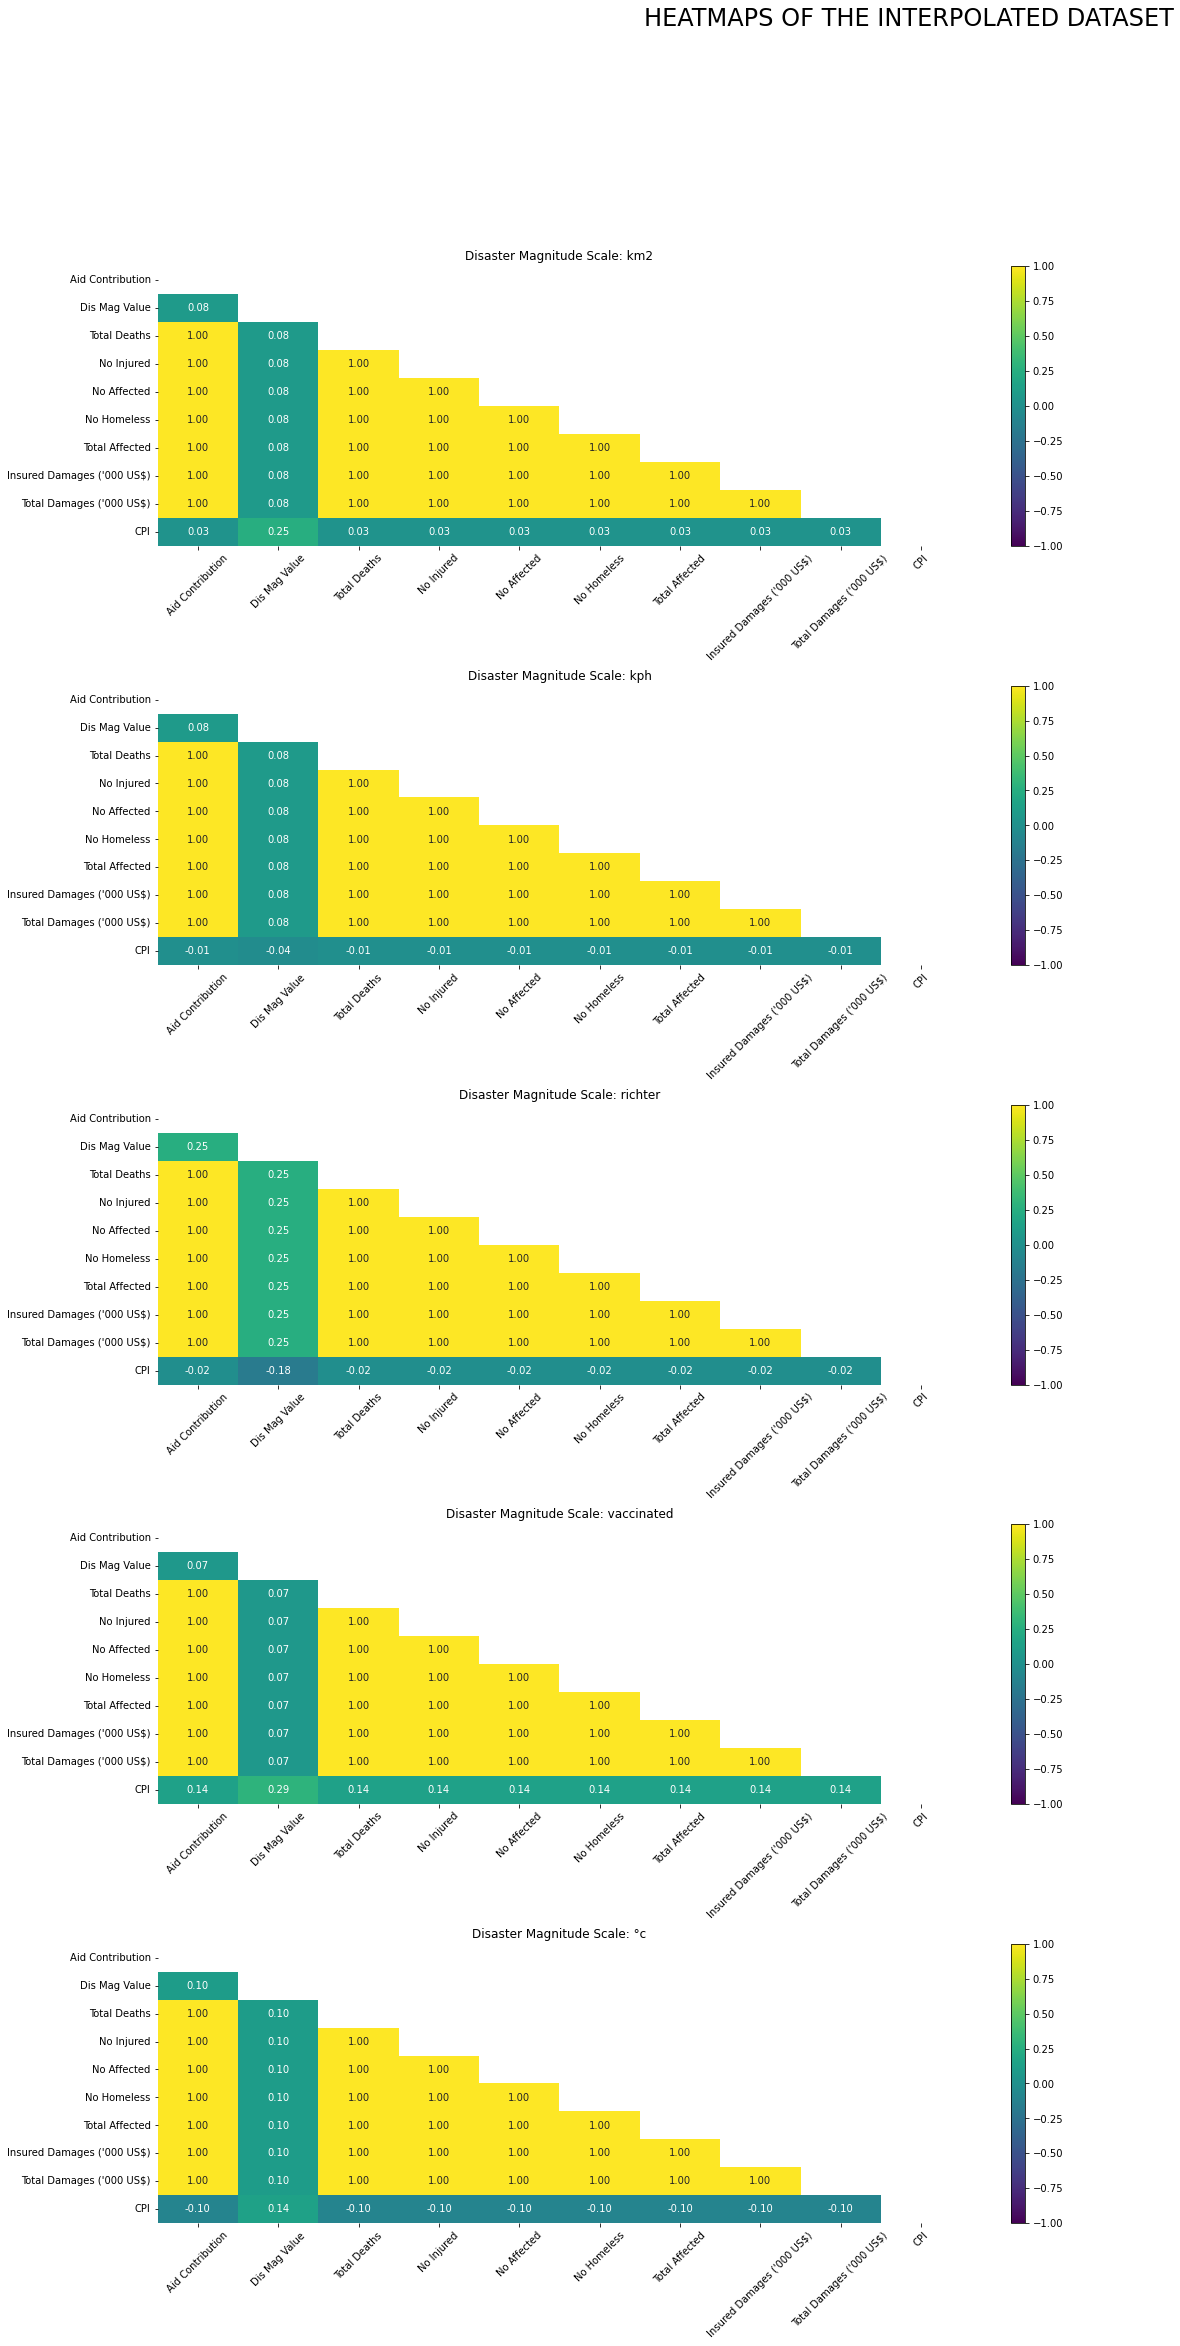

In [16]:
# Group the data by the Dis Mag Scale column
groups = df.groupby('Dis Mag Scale')

# Create a figure and an array of subplots
fig, axs = plt.subplots(nrows=len(groups), figsize=(18, 36))

# Select the columns to include in the heatmap
columns_to_include = ['Aid Contribution', 'Dis Mag Value', 'Total Deaths', 'No Injured', 'No Affected', 'No Homeless', 'Total Affected', "Insured Damages ('000 US$)", "Total Damages ('000 US$)", 'CPI']


# Iterate through the groups
for i, (name, group) in enumerate(groups):
    # Calculate the correlations for each group
    corr = group[columns_to_include].corr()

    # Create the mask for the lower triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Plot the heatmap for each group using heatmap
    sns.heatmap(corr, ax=axs[i], cmap="viridis", annot=True, fmt=".2f", vmin=-1, vmax=1, center=0, cbar=False, mask=mask)
    
    axs[i].set_title(f'Disaster Magnitude Scale: {name}')
    
    # Rotate the x tick labels by 45 degrees
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=45)
    
    # Set the line width of the border
    for key, spine in axs[i].spines.items():
        spine.set_linewidth(3)
        
    # Add a color bar to each plot
    cbar = axs[i].figure.colorbar(axs[i].collections[0], ax=axs[i])
    
# Adjust the layout
plt.subplots_adjust(hspace=0.5)

# Add a title
plt.suptitle('HEATMAPS OF THE INTERPOLATED DATASET', fontsize=24, ha="left")

# Save the figure
plt.savefig('Analysis/Plots/dataset-grouped-correlation-heathmap-interpolated.png', facecolor='white', bbox_inches='tight')

### Export the final interpolated version of the dataset in a csv format

In [17]:
df.to_csv("Dataset/1900_2021_DISASTERS_INTERPOLATED.csv")